In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import seaborn as sns
from sklearn.decomposition import PCA
sys.path.append('../')
from utils import *
from processing import *
import cv2 as cv
from image_registration import *
from skimage import color
import scipy as sp

import SimpleITK as sitk
from skimage.transform import rescale,resize
from pystackreg import StackReg
from PIL import Image

import ipywidgets as widgets
from ipywidgets import Box, IntSlider
import umap

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


No module named 'brainpy._c.composition'

          SPIKE
    Version     : 0.99.30
    Date        : 22-03-2022
    Revision Id : 563
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 


In [2]:
import pickle
with open('../processed_data/Coronal3D_UMAP_datainfo_decoded.pkl', 'rb') as fp:
    UMAP_datainfo = pickle.load(fp)
    
slice_order = ['slide1_2_R00','slide1_2_R01','slide1_2_R02','slide1_2_R03','slide1_2_R04','slide1_2_R05','slide1_2_R06',
              'slide1_2_R07','slide1_2_R08','slide3_5_R00','slide3_5_R10','slide3_5_R01','slide3_5_R02','slide3_5_R03',
              'slide3_5_R04','slide4_6_R00','slide4_6_R11','slide4_6_R01','slide4_6_R02','slide4_6_R03','slide4_6_R04',
              'slide3_5_R05']

# slice_order = ['slide1_2_R00','slide1_2_R01','slide1_2_R02','slide1_2_R03','slide1_2_R04','slide1_2_R05','slide1_2_R06',
#               'slide1_2_R07','slide1_2_R08','slide3_5_R00','slide3_5_R10','slide3_5_R01','slide3_5_R02','slide3_5_R03',
#               'slide3_5_R04','slide4_6_R00','slide4_6_R11','slide4_6_R01','slide4_6_R02','slide4_6_R03','slide4_6_R04',
#               'slide3_5_R05','slide3_5_R06','slide3_5_R07','slide3_5_R08','slide3_5_R11','slide3_5_R09','slide4_6_R05',
#               'slide4_6_R06','slide4_6_R07','slide4_6_R08','slide4_6_R09','slide4_6_R10','slide7_R00','slide7_R01',
#               'slide7_R02','slide7_R03']

# no_transform = ['slide3_4_R01']
# rotate_slice = ['slide1_2_R13','slide1_2_R12','slide1_2_R11','slide1_2_R10','slide1_2_R09','slide1_2_R08','slide1_2_R05','slide1_2_R04','slide1_2_R03']

In [3]:
def pad(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(int)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(int)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(int)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(int)
    return np.copy(np.pad(img, [(top_pad, bottom_pad), (left_pad, right_pad)], mode='constant'))

In [4]:
import h5py

idx = 0
umap_imgs = []
spec_idx_imgs = []
for slice in slice_order:
    data = UMAP_datainfo[slice_order[idx]]
    coord = data['coordinates']
    embedding = data['embeddings'][:,[1,7,8]]
    umap_img = color.rgb2gray(hyperspectral_vis(embedding,coord,True).transpose(1,0,2))
    umap_img = (umap_img - np.min(umap_img)) / (np.max(umap_img) - np.min(umap_img))
    #umap_img = IonImg(embedding_normal,coord,True,False)
    spec_idx_img = IonImg(np.arange(1,embedding.shape[0]+1),coord,True,False)
    umap_img = pad(umap_img,512,512)
    spec_idx_img = pad(spec_idx_img,512,512)
    # umap_img = np.rot90(umap_img)
    # spec_idx_img = np.rot90(spec_idx_img)
    # if slice in rotate_slice:
    #     umap_imgs_2.append(np.rot90(np.rot90(umap_img)))
    #     umap_img_upsampled = np.rot90(np.rot90(resize(umap_img,(512,1024),order=1)))
    #     spec_idx_img_upsampled = np.rot90(np.rot90(np.array(Image.fromarray(spec_idx_img).resize((umap_img_upsampled.shape[1],umap_img_upsampled.shape[0]), Image.NEAREST))))
    # else:
    #     umap_imgs_2.append(umap_img)
    #     umap_img_upsampled = resize(umap_img,(512,1024),order=1)
    #     spec_idx_img_upsampled = np.array(Image.fromarray(spec_idx_img).resize((umap_img_upsampled.shape[1],umap_img_upsampled.shape[0]), Image.NEAREST))
    #group = hf.create_group(slice)
    umap_imgs.append(umap_img)
    spec_idx_imgs.append(spec_idx_img)
    idx +=1

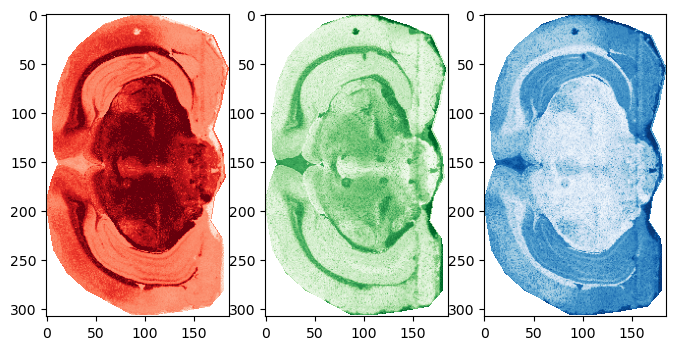

In [5]:
data = UMAP_datainfo[slice_order[18]]
embedding = data['embeddings'][:,[7,1,5]]
img = IonImg(embedding[:,0],data['coordinates'],False,False)
plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.imshow(img,'Reds',vmax=6)
img = IonImg(embedding[:,1],data['coordinates'],False,False)
plt.subplot(1,3,2)
plt.imshow(img,'Greens',vmax=5)
img = IonImg(embedding[:,2],data['coordinates'],False,False)
plt.subplot(1,3,3)
plt.imshow(img,'Blues',vmax=0)
#plt.savefig('umap_imgs_2.pdf',dpi=300)

In [ ]:
plt.figure(figsize=(6,7))
plt.imshow(hyperspectral_vis(embedding,data['coordinates'],True))

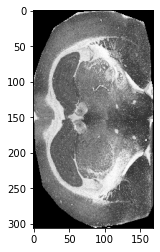

In [135]:
plt.imshow(color.rgb2gray(hyperspectral_vis(embedding,data['coordinates'],True)),'gray')

In [5]:
hf = h5py.File('../image_register/umap_unregistered.h5', 'w')
idx=0
for img in umap_imgs_pad:
    hf.create_dataset(slice_order[idx]+'_msi_img',data=img)
    idx+=1
hf.close()

NameError: name 'umap_imgs_pad' is not defined

In [9]:
import nibabel as nib
file_dir = '../'
epi_labels = nib.load(file_dir+'WHS_SD_rat_atlas_v2.nii.gz')
epi_t2 = nib.load(file_dir+'WHS_SD_rat_T2star_v1.01.nii.gz')
epi_fa = nib.load(file_dir+'WHS_SD_rat_FA_color_v1.01.nii.gz')

In [10]:
epi_labels_data = epi_labels.get_fdata()
epi_t2_data = epi_t2.get_fdata()

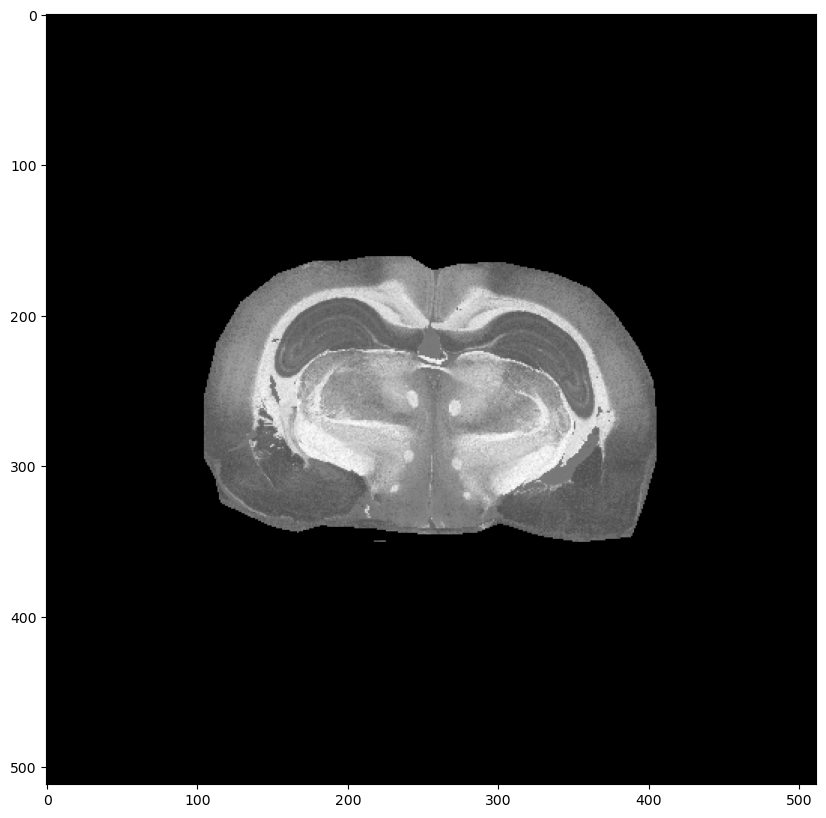

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(umap_imgs[14],'gray')

In [8]:
mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500,365,360,355,350,330,325,320,310,305,295,290,280,275,270,265]

In [9]:
mri_slice_masked.shape

NameError: name 'mri_slice_masked' is not defined

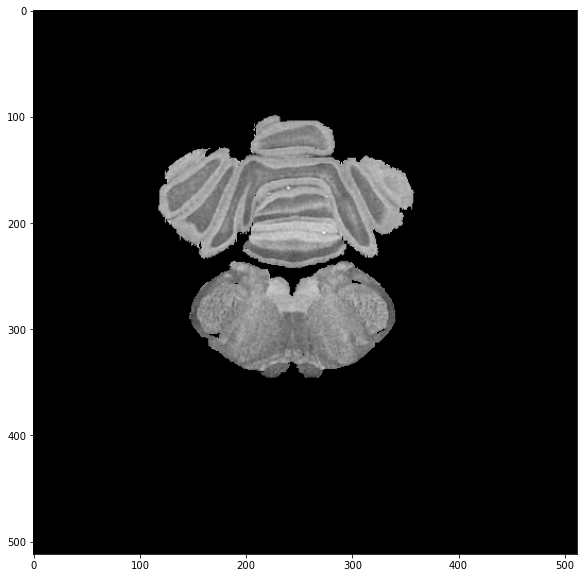

In [10]:
slice_no = 265
label_slice = epi_labels_data[:, slice_no, :].copy()
mri_slice = epi_t2_data[:, slice_no, :].copy()
label_slice_mask = label_slice.copy()
label_slice_mask[label_slice_mask>0] = 1

mri_slice_masked = mri_slice*label_slice_mask
plt.figure(figsize=(10,10))
plt.imshow(np.rot90(mri_slice_masked),'gray')

In [11]:
#mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500,365,360,355,350,330,325,320,310,305,295,290,280,275,270,265]
mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500]

mri_imgs = []
label_imgs = []
for i in range(len(mri_slice_num)):
    slice_no = mri_slice_num[i]

    label_slice = epi_labels_data[:, slice_no, :].copy()
    mri_slice = epi_t2_data[:, slice_no, :].copy()
    label_slice_mask = label_slice.copy()
    label_slice_mask[label_slice_mask>0] = 1

    mri_slice_masked = mri_slice*label_slice_mask
    #mri_slice_masked = (mri_slice_masked - np.min(mri_slice_masked)) / (np.max(mri_slice_masked) - np.min(mri_slice_masked))
    mri_slice_masked = mri_slice_masked/mri_slice_masked.max()
    #mri_slice_masked[label_slice_mask==0]+=1
    mri_slice_masked = np.flip(mri_slice_masked.T)
    mri_slice_label = np.flip(label_slice.T)

    mri_imgs.append(mri_slice_masked)
    label_imgs.append(mri_slice_label)
    
#     fig,axes = plt.subplots(1,2,figsize=(12,6))
#     ax = axes.ravel()
#     ax[0].set_title('mri slice {}'.format(slice_no))
#     ax[1].set_title('msi umap {}'.format(slice_order[i]))
#     ax[0].imshow(mri_slice_masked,'gray')
#     ax[1].imshow(umap_imgs[i],'gray')
#     plt.show()

In [10]:
def save_msi_transform_stack(file_name,img_stack):
    upsampled_imgs = []
    hf = h5py.File(file_name, 'w')
    idx = 0
    for slice in slice_order:
        img = np.rot90(img_stack[idx])
        if slice in rotate_slice:
            img_upsampled = np.rot90(np.rot90(resize(img,(512,1024),order=1)))
        else:
            img_upsampled = resize(img,(512,1024),order=1)
        upsampled_imgs.append(img_upsampled)
        hf.create_dataset(slice+'_msi_img',data=img_upsampled)
        idx+=1
    hf.close()
    return upsampled_imgs

In [601]:
# cv.imwrite('../mri_img.tiff',mri_slice_masked)
import h5py

hf = h5py.File('../image_register/coronal3D_image_reg.h5', 'w')
idx = 0
for slice in slice_order:
    hf.create_dataset(slice+'_umap_img',data=umap_imgs[idx])
    hf.create_dataset(slice+'_spec_idx_img',data=spec_idx_imgs[idx])
    hf.create_dataset(slice+'_mri_img',data=mri_imgs[idx])
    idx+=1
hf.close()

In [4]:
# from scipy.io import loadmat
# spec_idx_transformed = loadmat('../image_register/spec_idx_imgs_transformed.mat')['spec_idx_imgs_transformed']
# msi_imgs_transformed = loadmat('../image_register/msi_imgs_transformed.mat')['msi_imgs_transformed']
spec_idx_transformed = loadmat('../image_register/Matlab Registration/coronal_registration/spec_idx_imgs_transformed.mat')['spec_idx_imgs_transformed']

In [3]:
atlas_region = {'basal forebrain':82,'corpus collusum':67,'cortex':92,'corticofugal pathway':1,'hippocampal region':[95,96,97,98],'hypothalamus':48,'striatum':30,
                'thalamus':39,'brainstem':47,'superior colliculus':[50,55],'septal region':40}
slice_no = 19
fig,axes = plt.subplots(2,6,figsize=(15,5))
ax = axes.ravel()
idx = 0
label_imgs_use = []
for key in atlas_region.keys():
    ax[idx].imshow((np.isin(label_imgs[slice_no], atlas_region[key])))
    label_imgs_use.append((np.isin(label_imgs[slice_no], atlas_region[key])).astype(int))
    ax[idx].axis('off')
    ax[idx].set_title(key)
    idx+=1
fig.tight_layout()
fig,axes = plt.subplots(1,1,figsize=(3,3))
axes.imshow((np.isin(label_imgs[slice_no], [92,30,67,39,1,95,96,97,98,48,82,47,50,55,40])))

In [33]:
atlas_region.keys()

dict_keys(['basal forebrain', 'corpus collusum', 'cortex', 'corticofugal pathway', 'hippocampal region', 'hypothalamus', 'striatum', 'thalamus', 'brainstem', 'superior colliculus', 'septal region'])

In [32]:
from skimage import img_as_ubyte
from tifffile import imsave

def save_tiff_stack(imgs,file_name):
    img_stack = (np.stack(imgs))
    img_stack = img_stack/img_stack.max()
    imsave(file_name, img_stack)
    return img_stack

img_stack = save_tiff_stack(label_imgs_use,'../image_register/coronal_atlas_{}.tif'.format(slice_order[9]))

In [6]:
import image_registration
#file_dir = '../processed_data/coronal3D_propagated_decoded.h5'
file_dir = '/Volumes/Extreme SSD/deepMSI/processed_data/coronal3D_propagated_decoded_new.h5'
reg = image_registration.Image(data_dir=file_dir,registration_dir='../image_transform',group_order=slice_order)
reg.load_transform('../image_register/Matlab Registration/coronal_registration')
reg.load_data(True)

100%|███████████████████████████████████████████| 22/22 [00:24<00:00,  1.13s/it]


In [14]:
# cere_data = []
# cere_regions = []
# cere_slices = []
# for slice in slice_order[-4:]:
#     cere_data.append(reg.data[slice]['intens_mtx'])
#     cere_regions+=['cerebellum']*len(reg.data[slice]['intens_mtx'])
#     cere_slices+=[slice]*len(reg.data[slice]['intens_mtx'])

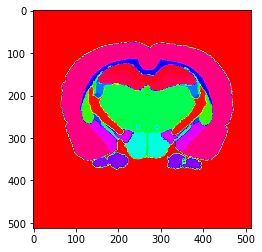

In [152]:
plt.imshow(label_imgs[9],'hsv')

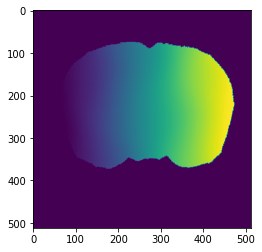

In [45]:
plt.imshow(reg.transform[slice_order[10]].T)

In [ ]:
sorted(list(set(reg.transform['slide1_2_R00'].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1)))

In [41]:
spec_region = {}
idx = 0
mz = reg.mzs
mz_filter = (mz>600)&(mz<1200)
slice_order_use = slice_order.copy()
#data_arr = []
regions_all = []
slices_all = []
for slice in slice_order_use:
    data = {}
    regions = []
    
    for key in atlas_region.keys():
        region_idx = np.array(sorted(list(set(reg.transform[slice].T[np.isin(label_imgs[idx],atlas_region[key])].astype(int)-1))))
        region_data = reg.data[slice]['intens_mtx'][list(region_idx[region_idx>=0])]
        data[key] = region_data
        #data_arr.append(region_data)
        regions+=[key]*region_data.shape[0]
        slices_all+=[slice]*region_data.shape[0]
    idx +=1
    spec_region[slice] = data
    regions_all+=regions
    #spec_region[slice]['region'] = regions

KeyboardInterrupt: 

In [16]:
metadata = pd.DataFrame({'regions':regions_all+cere_regions,'slice':slices_all+cere_slices})

In [17]:
metadata

,regions,slice
0,basal forebrain,slide1_2_R00
1,basal forebrain,slide1_2_R00
2,basal forebrain,slide1_2_R00
3,basal forebrain,slide1_2_R00
4,basal forebrain,slide1_2_R00
...,...,...
991355,cerebellum,slide3_5_R05
991356,cerebellum,slide3_5_R05
991357,cerebellum,slide3_5_R05
991358,cerebellum,slide3_5_R05


In [18]:
data_df = pd.DataFrame(np.concatenate([np.concatenate(data_arr),np.concatenate(cere_data)]),columns=reg.mzs)
import random
random.seed(19)
rows_id = random.sample(range(0, data_df.shape[0]), int(data_df.shape[0]*0.2))

NameError: name 'data_arr' is not defined

In [14]:
mzs = reg.mzs.round(4)
np.where(mzs==955.5929)

(array([1025]),)

In [51]:
intens_mtx.shape[0]*0.05

2009.8500000000001

In [58]:
slice_no = 19
intens_mtx = reg.data[slice_order[slice_no]]['intens_mtx']
atlas_region = {'basal forebrain':82,'corpus collusum':67,'cortex':92,'corticofugal pathway':1,'hippocampal region':[95,96,97,98],'hypothalamus':48,'striatum':30,
                'thalamus':39,'brainstem':47,'superior colliculus':[50,55],'septal region':40}
regions = []
data = []
for key in atlas_region.keys():
    region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],atlas_region[key])].astype(int)-1))))
    if region_idx.shape[0]>int(0.01*intens_mtx.shape[0]):
        region_data = intens_mtx[region_idx[region_idx>=0]]
        data.append(region_data)
        regions+=[key]*region_data.shape[0]

In [69]:
set(atlas_region.keys())-set(umap_spec_df[umap_spec_df['regions'].isin(region_show)].regions.unique())

{'basal forebrain', 'septal region', 'striatum'}

In [60]:
region_data = np.concatenate(data)
region_data_df = pd.DataFrame(region_data)
region_data_df.columns = mzs
region_data_df['region'] = regions

In [61]:
region_umap = umap.UMAP(n_components=2,n_neighbors=30,
                        min_dist=0.4,metric='cosine',random_state=19).fit_transform(region_data)

In [62]:
# plt.figure(figsize=(5,5))
# sns.set_palette('tab10')
# sns.scatterplot(region_umap[:,0],region_umap[:,1],s=1,hue=region_data_df['region'],alpha=1)

In [79]:
umap_spec_df[umap_spec_df['regions'].isin(region_show)].regions.unique()

array(['corpus collusum', 'cortex', 'corticofugal pathway',
       'hippocampal region', 'hypothalamus', 'thalamus', 'brainstem',
       'superior colliculus'], dtype=object)

In [78]:
colormaps = {'corpus collusum':(1,124/255,0,1), 'cortex':(252/255,245/255,0,1), 'corticofugal pathway':(0,1,246/255,1),
       'hippocampal region':(132/255,1,0,1), 'hypothalamus':(0,140/255,1,1), 'thalamus':(0,16/255,1,1),
         'brainstem':(114/255,0,1,1),'superior colliculus':(238/255,0,1,1),'basal forebrain':(1,0,0,1), 
             'septal region':(0,1,116/255,1), 'striatum':(8/255,1,0,1)}

In [80]:
umap_spec_df['regions'].unique()

array(['corpus collusum', 'cortex', 'corticofugal pathway',
       'hippocampal region', 'hypothalamus', 'thalamus', 'brainstem',
       'superior colliculus'], dtype=object)

In [82]:
umap_spec_df

,umap1,umap2,regions
0,10.955359,0.492925,corpus collusum
1,10.171620,5.492145,corpus collusum
2,11.451132,2.960752,corpus collusum
3,11.687677,1.002658,corpus collusum
4,12.507874,-0.139525,corpus collusum
...,...,...,...
35337,8.628386,-0.479506,superior colliculus
35338,7.969011,5.564022,superior colliculus
35339,9.671968,-0.062703,superior colliculus
35340,12.490349,-2.463674,superior colliculus


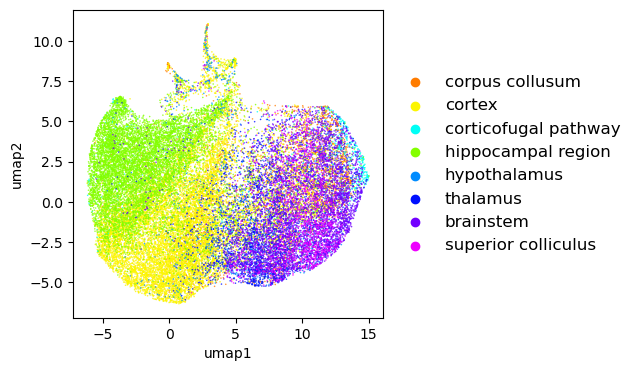

In [81]:
# colors=[(1,124/255,0,1),(252/255,245/255,0,1),(0,1,246/255,1),(132/255,1,0,1),
#         (0,140/255,1,1),(8/255,1,0,1),(0,16/255,1,1)]
colors=[(1,0,0,1),(1,124/255,0,1),(252/255,245/255,0,1),(8/255,1,0,1),(0,1,116/255,1)]

colors=[(1,124/255,0,1),(252/255,245/255,0,1),(0,1,246/255,1),(132/255,1,0,1),
        (0,140/255,1,1),(0,16/255,1,1),(114/255,0,1,1),(238/255,0,1,1)]

umap_spec_df = pd.DataFrame({'umap1':region_umap[:,0],'umap2':region_umap[:,1],
                                'regions':region_data_df['region']})
plt.figure(figsize=(4,4))
region_show = atlas_region.keys()
#region_show = ['molecular layer cerebellum','granule cell layer cerebellum']
sns.scatterplot(x='umap1',y='umap2',hue='regions',data=umap_spec_df[umap_spec_df['regions'].isin(region_show)],
                palette=[colormaps[key] for key in umap_spec_df['regions'].unique()],alpha=0.8,edgecolor=None,s=1,rasterized=True)
plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))
plt.savefig('../figures/2d_coronal_spec_umap_slice_20.pdf')


In [7]:
# data_df.to_pickle('F:/coronal3D_regional_pixel.pkl')
# metadata.to_pickle('F:/coronal3D_regional_pixel_metadata.pkl')
data_df = pd.read_pickle('F:/coronal3D_regional_pixel.pkl')
metadata = pd.read_pickle('F:/coronal3D_regional_pixel_metadata.pkl')

In [1]:
import umap
UMAP = umap.UMAP(n_neighbors=30,min_dist=0.5).fit_transform(data_df)

ModuleNotFoundError: No module named 'umap'

In [26]:
region_data = scMSAnalysis(metadata.iloc[rows_id])
region_data.preprocessing(data_df.iloc[rows_id]
                          ,norm_method='None',feat_drop_rate=0.001,cell_drop_rate=0.01)

filtered intensity matrix with shape (161906, 1156)


c:\users\richard\appdata\local\programs\python\python38\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [1]:
region_data.get_labels(['regions'])
region_data.analyze(n_neighbors=30, n_pcs=50, min_dist=0.5, resolution = 0.15,
              categories=['types'])

In [2]:
average_spec_region = []
regions = []
slices = []
average_spec_label = []
average_spec_label_onehot = []
for slice in slice_order:
    label_idx = 0
    for key in atlas_region.keys():
        label_onehot = np.array([0,0,0,0,0,0,0,0,0,0,0])
        if spec_region[slice][key].shape[0] != 0:
            spec = spec_region[slice][key].mean(0)
            average_spec_region.append(spec)
            slices.append(slice)
            regions.append(key)
            average_spec_label.append(label_idx)
            label_onehot[label_idx] = 1
            average_spec_label_onehot.append(label_onehot)
        label_idx+=1
average_spec_region = np.array(average_spec_region)
average_spec_label_onehot = np.array(average_spec_label_onehot)

In [43]:
average_spec_region = pd.read_pickle('../processed_data/average_spec_region.pkl')
average_spec_region_metadata = pd.read_pickle('../processed_data/metadata_average_spec_region.pkl')

In [28]:
average_spec_region_metadata['matter'] = matter

NameError: name 'matter' is not defined

In [72]:
average_spec_region_metadata.to_pickle('../processed_data/metadata_average_spec_region.pkl')

In [13]:
average_spec_region

,400.278496,400.285701,400.340944,402.021083,403.255567,404.292455,405.300395,406.279156,406.296220,407.957290,...,1065.425584,1065.540656,1067.697353,1080.437754,1081.397606,1085.447423,1086.450837,1088.453917,1088.767436,1097.418101
0,0.000979,0.000790,0.000045,0.000061,0.000177,0.000144,0.000571,0.000066,0.000058,0.000068,...,0.000105,0.000053,0.000137,0.000069,0.000128,0.000065,0.000061,0.000062,0.000086,0.000048
1,0.000516,0.000472,0.000099,0.000047,0.000151,0.000203,0.000848,0.000104,0.000174,0.000084,...,0.000158,0.000040,0.000190,0.000183,0.000183,0.000167,0.000121,0.000045,0.000084,0.000058
2,0.001160,0.000924,0.000035,0.000086,0.000193,0.000126,0.000462,0.000069,0.000039,0.000082,...,0.000091,0.000065,0.000080,0.000075,0.000122,0.000041,0.000046,0.000064,0.000082,0.000065
3,0.000404,0.000484,0.000071,0.000030,0.000113,0.000207,0.001141,0.000115,0.000213,0.000058,...,0.000297,0.000038,0.000315,0.000356,0.000359,0.000120,0.000097,0.000039,0.000063,0.000097
4,0.000956,0.000781,0.000045,0.000057,0.000183,0.000139,0.000584,0.000067,0.000060,0.000057,...,0.000107,0.000048,0.000121,0.000076,0.000128,0.000061,0.000059,0.000060,0.000087,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.000582,0.000523,0.000073,0.000098,0.000200,0.000163,0.000623,0.000074,0.000115,0.000127,...,0.000124,0.000046,0.000112,0.000162,0.000149,0.000116,0.000090,0.000062,0.000077,0.000070
159,0.000860,0.000751,0.000029,0.000127,0.000252,0.000114,0.000441,0.000053,0.000035,0.000097,...,0.000099,0.000052,0.000057,0.000090,0.000145,0.000038,0.000042,0.000064,0.000067,0.000074
160,0.000797,0.000709,0.000082,0.000103,0.000150,0.000161,0.000639,0.000093,0.000110,0.000120,...,0.000153,0.000073,0.000148,0.000232,0.000208,0.000128,0.000088,0.000043,0.000097,0.000077
161,0.000743,0.000667,0.000084,0.000082,0.000135,0.000173,0.000695,0.000091,0.000120,0.000114,...,0.000149,0.000072,0.000172,0.000230,0.000197,0.000152,0.000098,0.000043,0.000097,0.000071


In [30]:
sys.path.append('../scms_py')
from scMSData import scMSData
from analysis import scMSAnalysis

avg_region  = scMSAnalysis(average_spec_region_metadata)
avg_region.preprocessing(average_spec_region, norm_method='None',feat_drop_rate=0.005,cell_drop_rate=0.005)

filtered intensity matrix with shape (163, 1156)


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [50]:
avg_region.get_labels(['regions','slices','matter'])
avg_region.analyze(n_neighbors=25, n_pcs=20, min_dist=0.5, resolution = 0.15,
              categories=['regions','matter'])

computing neighbors..
performing umap...


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'regions' as categorical
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'slices' as categorical
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remo

performing clustering...


In [51]:
show_embed = widgets.interactive(avg_region.show_cellEmbed, label=avg_region.adata.obs.columns,
                                 embed_method=avg_region.adata.obsm.keys(),size=(8,10,0.1));

In [52]:
grey_list = ['hippocampal region','cortex','hypothalamus','thalamus']
white_list = ['corticofugal pathway','corpus collusum']
mixed_list = ['superior colliculus','brainstem','basal forebrain','striatum','septal region']

matter = []
for region in average_spec_region_metadata['regions']:
    if region in grey_list:
        matter.append('grey')
    if region in white_list:
        matter.append('white')
    if region in mixed_list:
        matter.append('mixed')

In [53]:
show_embed

interactive(children=(Dropdown(description='label', options=('regions', 'slices', 'matter', 'leiden'), value='…

In [120]:
from sklearn.decomposition import PCA
import umap
pca = PCA(n_components=20)
pca = pca.fit(average_spec_region)

pca_scores = pca.fit_transform(average_spec_region)
UMAP = umap.UMAP(n_neighbors=15,min_dist=0.7,metric='cosine',random_state=19).fit_transform(average_spec_region)

In [98]:
len(matter)

163

In [35]:
# plt.figure(figsize=(5,5))
# # plt.ylim([-10,12])
# # plt.xlim([-50,50])
# #1gm 6wm
# colors = [cmap(norm(1)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6))]
# sns.scatterplot(x='PC1',y='PC2',hue='regions',data=pca_avg_spec_df,alpha=0.8,edgecolor='black',legend=False)

In [50]:
# plt.figure(figsize=(10,5))
# plt.stem(mz[mz_filter],pca.components_[0],markerfmt=' ',basefmt='black',linefmt='slategray',label='PC1 components')
# plt.stem(mz[mz_filter],pca.components_[1],markerfmt=' ',basefmt='black',linefmt='salmon',label='PC1 components')
# plt.legend()
# plt.xlabel('m/z')

In [3]:
from sklearn.cross_decomposition import PLSRegression
slice_num = 29
data_train = []
label = []
data_label = []
label_idx = 0
for key in atlas_region.keys():
    dummy_label = np.array([0,0,0,0,0,0,0])
    data_train.append(spec_region[slice_order[slice_num]][key])
    label.append([key]*spec_region[slice_order[slice_num]][key].shape[0])
    #dummy_label[label_idx] = 1
    data_label.append([label_idx]*spec_region[slice_order[slice_num]][key].shape[0])
    label_idx +=1
data_train = np.concatenate(data_train)
data_label = np.concatenate(data_label)
label = np.concatenate(label)

In [139]:
average_spec_region_metadata['slices'].unique().shape

(22,)

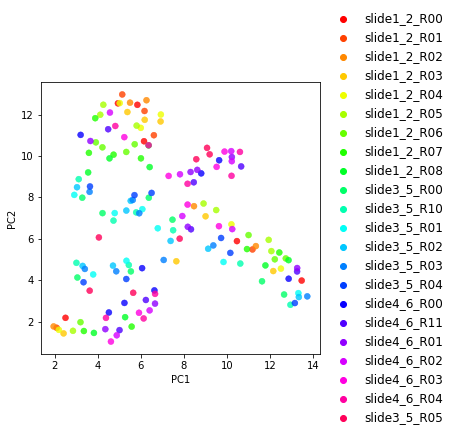

In [141]:
import matplotlib
cmap = matplotlib.cm.get_cmap('hsv')
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=22.0)
colors = [cmap(norm(i)) for i in range(0,22)]

pca_avg_spec_df = pd.DataFrame({'PC1':UMAP[:,0],'PC2':UMAP[:,1],
                                'regions':average_spec_region_metadata['regions'],
                                'slices':average_spec_region_metadata['slices'],
                               'matter':average_spec_region_metadata['matter']})
plt.figure(figsize=(5,5))
#plt.ylim([-0.03,0.04])
# plt.xlim([-50,50])
region_show = atlas_region.keys()
#region_show = ['molecular layer cerebellum','granule cell layer cerebellum']
sns.scatterplot(x='PC1',y='PC2',hue='slices',data=pca_avg_spec_df[pca_avg_spec_df['regions'].isin(region_show)],palette=colors,alpha=0.8,edgecolor=None)
plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))
plt.savefig('../figures/3d_coronal_avg_spec_umap_slice_new.pdf')


In [84]:
import xgboost
model = xgboost.XGBClassifier(n_estimators=100,random_state=19,n_jobs=8)
model.fit(average_spec_region,average_spec_label)

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:01:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=19, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Confusion matrix, without normalization
[[13  0  0  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  7]]


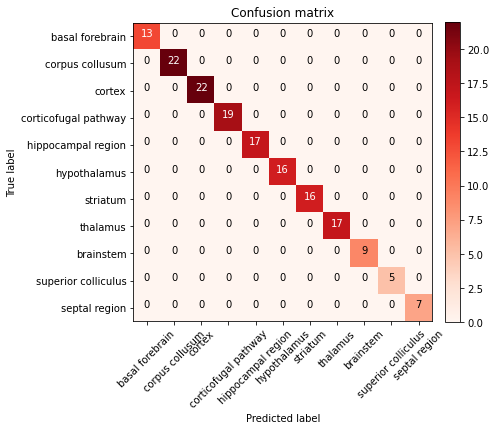

In [142]:
from sklearn.metrics import classification_report, confusion_matrix,multilabel_confusion_matrix

pred = model.predict(average_spec_region)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(7,7))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('../figures/regional_confusion_mtx.pdf')
    
cf_matrix = confusion_matrix(average_spec_label,pred)

plot_confusion_matrix(cf_matrix, classes=atlas_region.keys())

<StemContainer object of 3 artists>

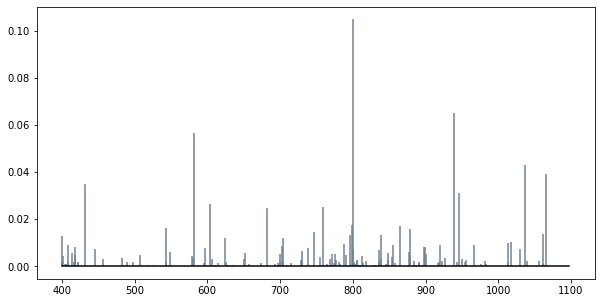

In [178]:
plt.figure(figsize=(10,5))
feature_rank = np.argsort(model.feature_importances_)[::-1]
plt.stem(mz,model.feature_importances_,markerfmt=' ',basefmt='black',linefmt='slategray',label='PC1 components')

In [43]:
# plsr = PLSRegression(n_components=30, scale=False)
# plsr.fit(average_spec_region, average_spec_label_onehot)

In [44]:
# plt.figure(figsize=(5,5))
# plsr_df = pd.DataFrame({'w1':plsr.x_scores_[:,0],'w2':plsr.x_scores_[:,1],'region':regions})
# colors = [cmap(norm(i)) for i in range(1,8)]
# sns.scatterplot(x='w1',y='w2',hue='region',data=plsr_df,alpha=0.7,palette=colors,edgecolor='black')
# plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))


In [45]:
# plt.figure(figsize=(5,5))
# plsr_df = pd.DataFrame({'w1':plsr.x_scores_[:,0],'w2':plsr.x_scores_[:,1],'region':regions})
# colors = [cmap(norm(1)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6)),cmap(norm(1)),cmap(norm(6))]
# sns.scatterplot(x='w1',y='w2',hue='region',data=plsr_df,alpha=0.7,palette=colors,edgecolor='black')
# plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))

Text(0.5, 0, 'm/z')

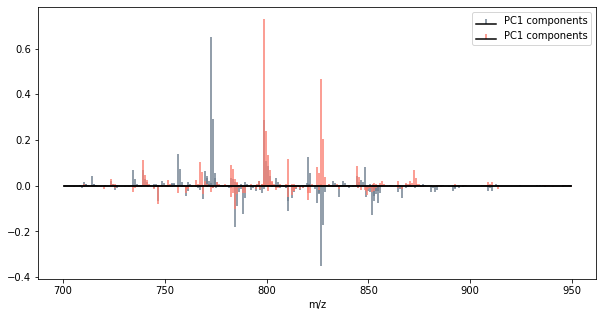

In [43]:
plt.figure(figsize=(10,5))
plt.stem(mz[mz_filter],plsr.x_loadings_[:,0],markerfmt=' ',basefmt='black',linefmt='slategray',label='PC1 components')
plt.stem(mz[mz_filter],plsr.x_loadings_[:,1],markerfmt=' ',basefmt='black',linefmt='salmon',label='PC1 components')
plt.legend()
plt.xlabel('m/z')

In [44]:
variance_in_x = np.var(plsr.x_scores_, axis = 0) 
total_variance_in_x = np.var(average_spec_region, axis = 0).sum()
fractions_of_explained_variance = variance_in_x / total_variance_in_x

In [45]:
weights = abs(plsr.x_weights_)@fractions_of_explained_variance
feature_rank = np.argsort(weights)[::-1]

In [46]:
# colors = [cmap(norm(i)) for i in range(1,8)]
# sns.boxplot(x=regions,y=average_spec_region[:,feature_rank_plsr[i]],showfliers=False,palette=colors,hue=regions)
# plt.legend(frameon=False,fontsize=12,ncol=1,loc='center left',bbox_to_anchor=(1, 0.5))

In [67]:
reg.IonImg_transform(reg.data[slice_order_use[19]]['intens_mtx'][:,feature_rank[i]],
                           reg.transform[slice_order_use[19]],True)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

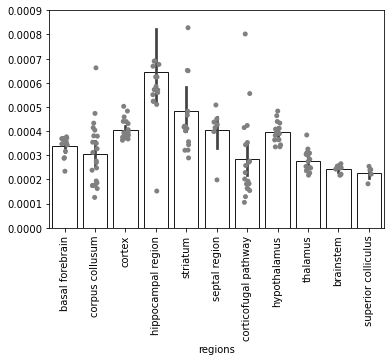

In [45]:
fig=sns.barplot(y=average_spec_region.values[:,887],x=average_spec_region_metadata['regions'],
                facecolor=(0, 0, 0, 0),edgecolor=".1")
sns.stripplot(y=average_spec_region.values[:,887],x=average_spec_region_metadata['regions'],color='gray')
plt.ylim([0,0.0009])
fig.tick_params(axis='x', labelrotation= 90)
plt.savefig('../figures/mzidx887_barplot.pdf')

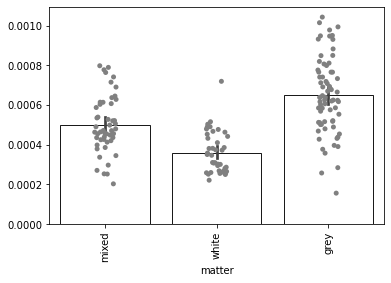

In [41]:
fig=sns.barplot(y=average_spec_region.values[:,859],x=average_spec_region_metadata['matter'],
                facecolor=(0, 0, 0, 0),edgecolor=".1")
sns.stripplot(y=average_spec_region.values[:,859],x=average_spec_region_metadata['matter'],color='gray')
fig.tick_params(axis='x', labelrotation= 90)

0
m/z 919.7499641560194
3
m/z 582.2984109401708
8
m/z 787.5496944315205


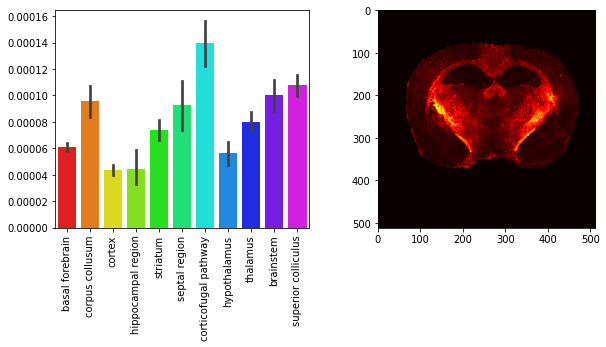

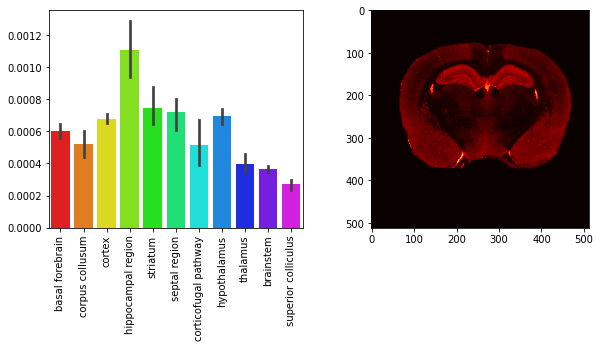

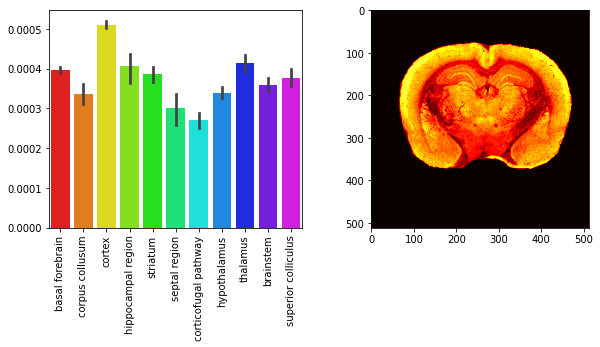

In [186]:
colors = [cmap(norm(i)) for i in range(0,11)]

for i in [0,3,8]:
    print(i)
    fig,axes = plt.subplots(1,2,figsize=(10,4))
    ax = axes.ravel()
    sns.barplot(x=regions,y=average_spec_region[:,feature_rank[i]],ax=ax[0],palette=colors)
    #sns.stripplot(x=regions,y=average_spec_region[:,feature_rank[i]],ax=ax[0],color='.3',size=4)
    ax[0].tick_params(axis='x', labelrotation= 90)
    ax[1].imshow(reg.IonImg_transform(reg.data[slice_order_use[9]]['intens_mtx'][:,feature_rank[i]],
                           reg.transform[slice_order_use[9]],True).T,'hot')
    print('m/z {}'.format(mz[feature_rank[i]]))
    fig.savefig('../figures/coronal_regional_{}.pdf'.format(i))

In [4]:
# with open('../Coronal3D_annotation_decoded.pkl', 'rb') as fp:
#     annot_df = pickle.load(fp)

In [5]:
# annot_df[annot_df['index']==feature_rank[0]]

In [108]:
img_set = reg.get_3DImages_transform(456,True)

In [143]:
from skimage import img_as_ubyte
from tifffile import imsave

def save_tiff_stack(imgs,file_name):
    img_stack = (np.stack(imgs))
    #img_stack = img_stack/img_stack.max()
    imsave(file_name, img_stack)
    return img_stack

#img_stack = save_tiff_stack(img_set,'../image_register/coronal_456mzidx.tif')

In [144]:
for key in atlas_region.keys():
    print(key)

basal forebrain
corpus collusum
cortex
corticofugal pathway
hippocampal region
hypothalamus
striatum
thalamus
brainstem
superior colliculus
septal region


In [145]:
mri_label_imgs = np.swapaxes(epi_labels_data[:,500:645,:].copy(),0,1)
mri_label_imgs_use = np.empty(mri_label_imgs.shape)
mri_label_imgs_use[:] = np.nan
idx = 0
for key in atlas_region.keys():
    mri_label_imgs_use[np.isin(mri_label_imgs, atlas_region[key])] = idx
    #mri_label_imgs_use[np.isin(mri_label_imgs, atlas_region[key])] = average_spec_region[np.where(np.array(regions)==key),feature_rank[8]].mean()
    idx += 1

In [239]:
mz

array([1099.49614656, 1097.42221846, 1088.76951838, ...,  206.05600997,
        177.01631856,  176.00867948])

In [175]:
img_stack = save_tiff_stack(mri_label_imgs_use,'../image_register/mri_label_spec_avg_intens_8.tif')

In [173]:
average_spec_region.iloc[np.where(np.array(regions)==key)[0],350:950]

,688.393704,688.430878,688.492840,689.071415,689.360885,689.398111,689.418793,689.642200,691.473553,692.386898,...,908.602846,909.546463,910.665890,911.442105,911.567893,911.671817,912.503639,912.596718,913.462268,913.500634
0,0.001516,0.000178,0.000079,0.000088,0.000072,0.000561,0.000101,0.000058,0.000063,0.000075,...,0.000301,0.000280,0.001027,0.000073,0.000348,0.000622,0.000120,0.000192,0.001981,0.000211
6,0.001529,0.000178,0.000079,0.000089,0.000072,0.000567,0.000103,0.000057,0.000061,0.000073,...,0.000307,0.000281,0.001007,0.000074,0.000353,0.000612,0.000121,0.000190,0.002005,0.000218
11,0.001609,0.000187,0.000081,0.000093,0.000072,0.000597,0.000112,0.000062,0.000073,0.000080,...,0.000289,0.000297,0.001021,0.000076,0.000336,0.000623,0.000123,0.000202,0.001819,0.000231
16,0.001494,0.000183,0.000077,0.000086,0.000071,0.000559,0.000103,0.000060,0.000065,0.000075,...,0.000311,0.000275,0.001055,0.000069,0.000350,0.000638,0.000117,0.000192,0.001858,0.000183
23,0.001529,0.000187,0.000081,0.000090,0.000070,0.000567,0.000107,0.000063,0.000069,0.000076,...,0.000306,0.000292,0.001062,0.000072,0.000340,0.000643,0.000120,0.000198,0.001757,0.000245
29,0.001756,0.000205,0.000099,0.000117,0.000078,0.000634,0.000120,0.000076,0.000078,0.000078,...,0.000261,0.000351,0.000990,0.000092,0.000292,0.000601,0.000121,0.000208,0.001620,0.000563
37,0.001592,0.000192,0.000080,0.000105,0.000070,0.000595,0.000103,0.000065,0.000065,0.000066,...,0.000297,0.000290,0.001004,0.000083,0.000320,0.000599,0.000112,0.000172,0.001830,0.000333
45,0.001609,0.000190,0.000073,0.000102,0.000073,0.000607,0.000092,0.000068,0.000058,0.000062,...,0.000309,0.000251,0.001169,0.000082,0.000324,0.000678,0.000122,0.000147,0.001992,0.000224
53,0.001544,0.000184,0.000072,0.000101,0.000070,0.000585,0.000088,0.000069,0.000056,0.000060,...,0.000311,0.000251,0.001186,0.000083,0.000327,0.000680,0.000121,0.000143,0.002009,0.000228
61,0.002549,0.000263,0.000067,0.000111,0.000064,0.000878,0.000091,0.000054,0.000056,0.000052,...,0.000195,0.000202,0.001557,0.000112,0.000218,0.000973,0.000188,0.000155,0.002789,0.000134


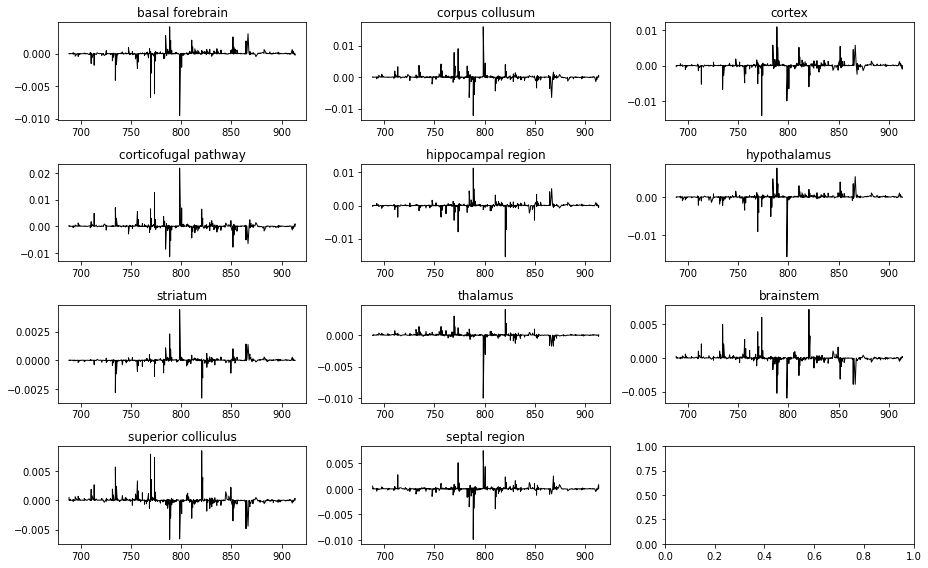

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

<Figure size 216x108 with 0 Axes>

In [174]:
mz_filter = (mz<900)&(mz>680)
idx=0
plt.rcParams["axes.grid"] = False
fig,axes = plt.subplots(4,3,figsize=(13,8))
ax = axes.ravel()
for key in atlas_region.keys():
    plt.figure(figsize=(3,1.5))
    #for i in range(mz[mz_filter].size):
    avg_spec = average_spec_region.iloc[np.where(np.array(regions)==key)[0],350:950].mean(0)
    diff_spec = (average_spec_region.iloc[np.where(np.array(regions)!=key)[0],350:950].mean(0)-avg_spec)
    ax[idx].plot(average_spec_region.columns[350:950],diff_spec,c='k',alpha=1,linewidth=1)
    ax[idx].set_title(key)
    idx+=1
fig.tight_layout()
fig.savefig('../figures/coronal_regional_spec_diff_new.pdf')

In [33]:
import scanpy as sc
import anndata

In [44]:
adata = anndata.AnnData(average_spec_region)
adata.obs['region'] = average_spec_region_metadata['regions'].values
features = np.round(mz,4).astype(str)
adata.var['mzs'] = features
adata.var_names = features
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

Transforming to str index.


In [45]:
adata.obs['region']

0           basal forebrain
1           corpus collusum
2                    cortex
3        hippocampal region
4                  striatum
               ...         
158    corticofugal pathway
159      hippocampal region
160                thalamus
161               brainstem
162     superior colliculus
Name: region, Length: 163, dtype: object

In [46]:
features[rank_shap[::-1][:15]].astype(str)

array(['754.4754', '917.527', '848.5986', '606.4142', '787.5466',
       '898.5732', '432.3452', '775.6028', '1061.6543', '758.5105',
       '938.6982', '596.8163', '1029.6289', '1013.6549', '800.1062'],
      dtype='<U32')

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'region' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


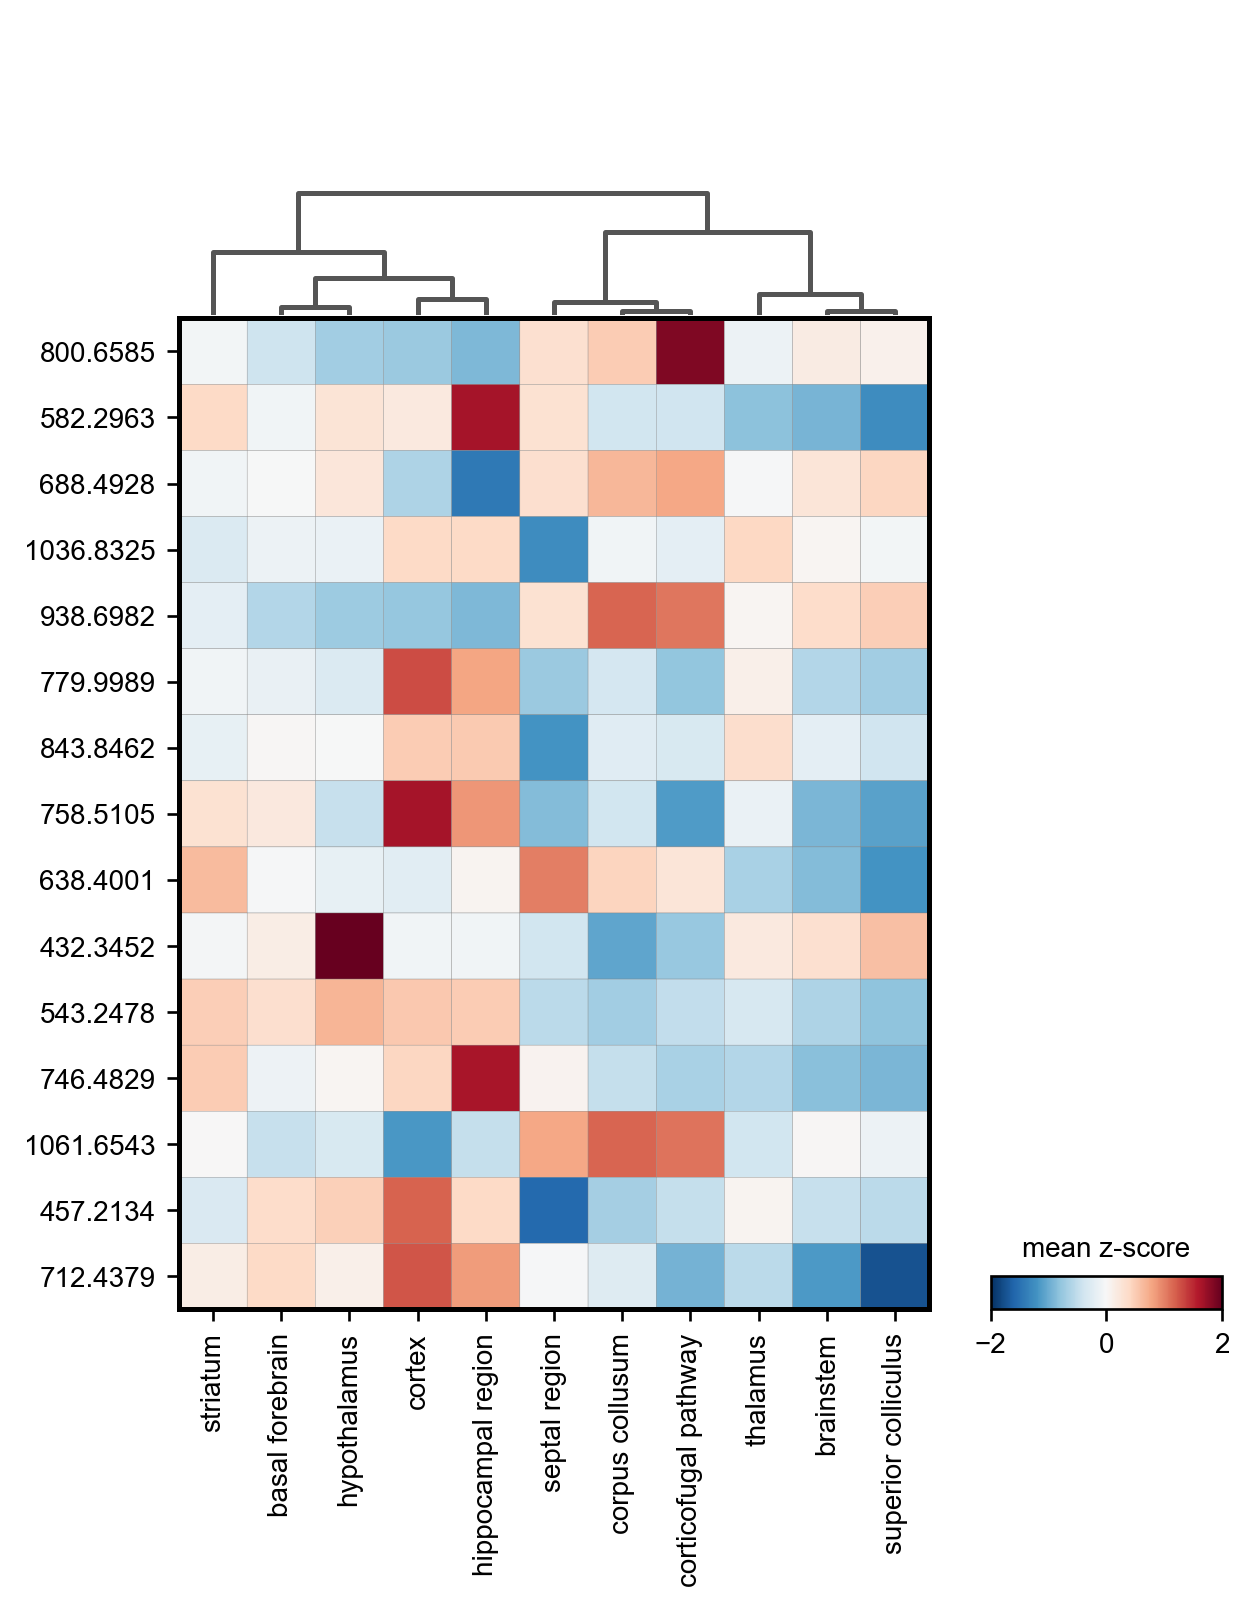

In [47]:
sc.settings.set_figure_params(dpi=120, facecolor='white',fontsize=10,figsize=(3,3))
sc.pl.matrixplot(adata, features[rank_entropy[::-1][:15]], 'region', dendrogram=True,swap_axes=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',save='3Dcoronal_regional_zscore.pdf')


In [49]:
sns.barplot(x=model.feature_importances_[feature_rank[:15]],y=features[feature_rank[:15]])

NameError: name 'feature_rank' is not defined

In [473]:
annot_df2 = []
category = []
for mz in annot_df['Input m/z'].unique():
    df = annot_df[annot_df['Input m/z']==mz]
    annot_df2.append(df[df['ppm']==df['ppm'].min()])
annot_df2 = pd.concat(annot_df2)
annot_df2 = annot_df2[annot_df2['ppm']<2]

lipid_class = [name.split(' ')[0] for name in annot_df2['Name']]
annot_df2['lipid class'] = lipid_class

In [474]:
annot_df_h = annot_df2[annot_df2['lipid class'].isin(['PS','PC','PA','PI','PE','PG','HexCer','Cer','SM','LPC','LPE','LPA','LPI'])]

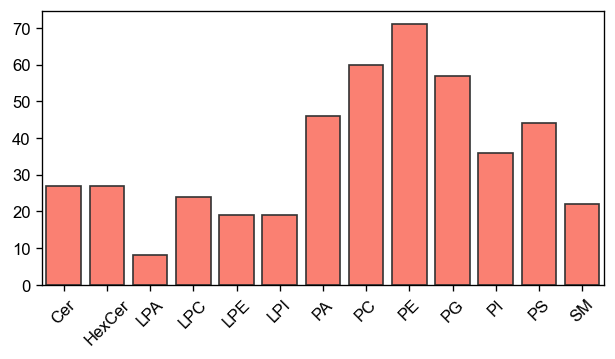

In [475]:
annot_hist = np.unique([name.split(' ')[0] for name in annot_df_h[(annot_df_h['ppm']<2)]['Name'].unique()], return_counts=True)
#annot_hist2 = np.unique([name.split(' ')[0] for name in annot_df2[annot_df2['ppm']<2]['Name'].unique()], return_counts=True)
plt.figure(figsize=(6,3))
sns.barplot(x=annot_hist[0],y=annot_hist[1],dodge=False,linewidth=1, facecolor='salmon',edgecolor=".2")
plt.xticks(rotation=45)
plt.savefig('../figures/lipidannot_hist_0.4.pdf')

<AxesSubplot:ylabel='lipid class'>

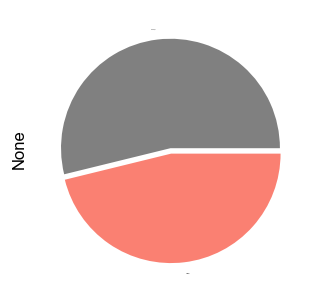

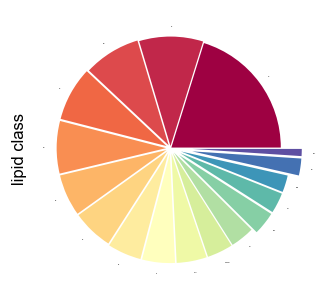

In [627]:
pd.DataFrame(np.isin(reg.mzs,annot_df2['Input m/z'].unique())).value_counts().plot(
    kind='pie', fontsize=0, colors=['grey','salmon'],explode=[0,0.05])
plt.savefig('../figures/lipidmaps_annotate.pdf')
plt.figure()
explode=[0.01,0.02,0.03,0.04,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.2,0.2]
annot_df2.loc[(annot_df2['lipid class'].isin(['TG','DG','ST','CerP','PS','PC','PA','PI','PE','PG','HexCer','Cer','SM','LPC','LPE','LPA','LPI']))]['lipid class'].value_counts().plot(
    kind='pie', fontsize=0,cmap = 'Spectral',explode=explode)

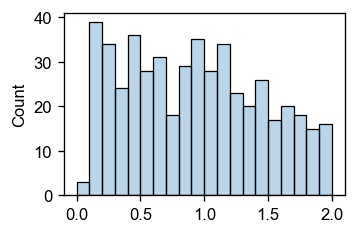

In [653]:
plt.figure(figsize=(3,2))
sns.histplot(annot_df2['ppm'].unique(),bins=20,kde=False,alpha=0.3)
plt.savefig('../figures/ppm_dist.pdf')

In [382]:
average_spec_region_annot = average_spec_region[:,np.isin(reg.mzs,annot_df2['Input m/z'].unique())]

In [200]:
treated_data

,400.278496,400.285701,400.340944,402.021083,403.255567,404.292455,405.300395,406.279156,406.296220,407.957290,...,1065.425584,1065.540656,1067.697353,1080.437754,1081.397606,1085.447423,1086.450837,1088.453917,1088.767436,1097.418101
35,0.000643,0.000519,0.000100,0.000060,0.000158,0.000195,0.000707,0.000087,0.000134,0.000112,...,0.000128,0.000043,0.000178,0.000120,0.000127,0.000148,0.000120,0.000051,0.000078,0.000042
43,0.000835,0.000672,0.000069,0.000063,0.000175,0.000171,0.000622,0.000078,0.000092,0.000072,...,0.000110,0.000053,0.000162,0.000092,0.000126,0.000097,0.000081,0.000049,0.000067,0.000042
52,0.001109,0.000856,0.000060,0.000077,0.000158,0.000167,0.000586,0.000087,0.000071,0.000087,...,0.000102,0.000081,0.000135,0.000107,0.000123,0.000063,0.000071,0.000052,0.000079,0.000053
60,0.001117,0.000861,0.000061,0.000075,0.000156,0.000171,0.000601,0.000089,0.000074,0.000083,...,0.000102,0.000082,0.000137,0.000108,0.000123,0.000063,0.000071,0.000051,0.000078,0.000052
68,0.000896,0.000863,0.000049,0.000103,0.000159,0.000139,0.000580,0.000079,0.000065,0.000104,...,0.000158,0.000087,0.000123,0.000219,0.000236,0.000088,0.000057,0.000060,0.000079,0.000085
76,0.000725,0.000821,0.000048,0.000118,0.000141,0.000149,0.000534,0.000085,0.000059,0.000131,...,0.000191,0.000075,0.000123,0.000266,0.000269,0.000096,0.000055,0.000073,0.000084,0.000100
84,0.000868,0.000865,0.000046,0.000110,0.000159,0.000138,0.000582,0.000081,0.000067,0.000110,...,0.000172,0.000085,0.000125,0.000238,0.000254,0.000086,0.000055,0.000064,0.000075,0.000092
92,0.000876,0.000859,0.000047,0.000111,0.000161,0.000133,0.000590,0.000080,0.000070,0.000111,...,0.000174,0.000082,0.000130,0.000238,0.000255,0.000087,0.000056,0.000062,0.000074,0.000092
99,0.000871,0.000856,0.000048,0.000110,0.000157,0.000134,0.000600,0.000082,0.000074,0.000111,...,0.000177,0.000083,0.000133,0.000247,0.000257,0.000090,0.000058,0.000062,0.000075,0.000094
107,0.000893,0.000828,0.000057,0.000106,0.000158,0.000133,0.000612,0.000085,0.000083,0.000110,...,0.000159,0.000080,0.000136,0.000228,0.000230,0.000101,0.000067,0.000055,0.000086,0.000086


In [233]:
from scipy.stats import ranksums
treated_data = average_spec_region.iloc[np.array(regions)=='hippocampal region'].values
nontreated_data = average_spec_region.iloc[np.array(regions)!='hippocampal region'].values
treated_mean = treated_data.mean(0)
nontreated_mean = nontreated_data.mean(0)
log2fold = np.log2(treated_mean/nontreated_mean)
log10pvals = np.array([-np.log10(ranksums(treated_data[:,i], nontreated_data[:,i])[1]) for i in range(treated_data.shape[1])])


No handles with labels found to put in legend.


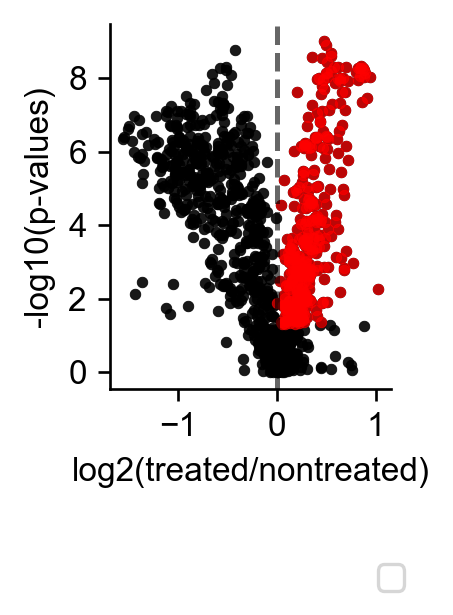

In [248]:
fig,axes = plt.subplots(1,1,figsize=(1.5,2))
df = pd.DataFrame({'log2(FC)':log2fold,'-log10(p)':log10pvals})
sns.scatterplot(x='log2(FC)',y='-log10(p)',data=df,s=10,alpha=0.9,ax=axes,color='k',edgecolor='k')
sns.scatterplot(x='log2(FC)',y='-log10(p)',data=df[(df['-log10(p)']>1.3)&(df['log2(FC)']>0)],s=10,alpha=0.7,ax=axes,color='red',edgecolor='red')

axes.axvline(0,linestyle='--',c='k',alpha=0.6)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('log2(treated/nontreated)')
plt.ylabel('-log10(p-values)')
plt.legend(loc="lower center",ncol=7,bbox_to_anchor=(1, -0.6),fontsize=10)
plt.savefig('../figures/coronal3d_hip_volcano_new.pdf')


In [7]:
# marker_filter = (df['-log10(p)']>1.3)&(df['log2(FC)']>0)
# mz_marker = reg.mzs[np.isin(reg.mzs,annot_df2['Input m/z'].unique())][marker_filter][log10pvals[marker_filter].argsort()[::-1]]

In [39]:
mzs = np.load('../processed_data/coronal3d_mz.npy')
adducts = ['M+H','M+Na','M+K']
site_url = 'https://www.lipidmaps.org/rest/moverz/LIPIDS'

annot_df, matched, unmatched = LipidMaps_annotate([730.5756], adducts, 7, site_url)


  0%|                                                     | 0/1 [00:00<?, ?it/s]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


In [40]:
annot_df

,Input m/z,Matched m/z,Delta,Name,Formula,Ion
0,730.5756,730.5745,0.0011,CerP 41:2;O3,C41H81NO7P,[M+H]+
1,730.5756,730.5745,0.0011,LPC 33:2,C41H81NO7P,[M+H]+
2,730.5756,730.5745,0.0011,LPC O-33:3;O,C41H81NO7P,[M+H]+
3,730.5756,730.5745,0.0011,PC O-33:2,C41H81NO7P,[M+H]+
4,730.5756,730.5745,0.0011,PE O-36:2,C41H81NO7P,[M+H]+
5,730.5756,730.5721,0.0035,LPC O-31:0;O,C39H82NO7PNa,[M+Na]+
6,730.5756,730.5721,0.0035,LPE O-34:0;O,C39H82NO7PNa,[M+Na]+
7,730.5756,730.5746,0.0010,ACer 43:2;O3,C43H81NO5K,[M+K]+
8,730.5756,730.5746,0.0010,Cer 43:3;O4,C43H81NO5K,[M+K]+


In [596]:
marker_class = []
for mz_marker_ in mz_marker:
    marker_class.append(annot_df2[annot_df2['Input m/z']==mz_marker_]['lipid class'].values[0])

NameError: name 'reg' is not defined

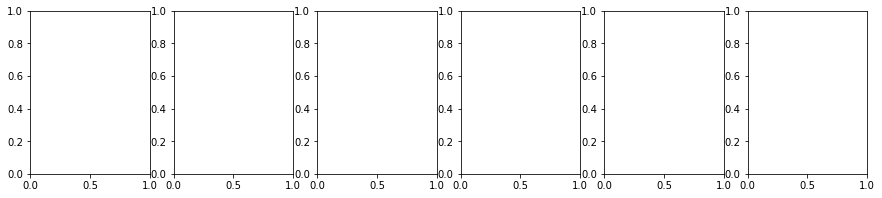

In [14]:
idx = 859
plt.rcParams["axes.grid"] = False
fig,axes=plt.subplots(1,6,figsize=(15,3))
ax = axes.ravel()
ax[0].imshow(reg.get_3DImages_transform(idx,True)[3],'hot')
ax[1].imshow(reg.get_3DImages_transform(idx,True)[5],'hot')
ax[2].imshow(reg.get_3DImages_transform(idx,True)[8],'hot')
ax[3].imshow(reg.get_3DImages_transform(idx,True)[13],'hot')
ax[4].imshow(reg.get_3DImages_transform(idx,True)[16],'hot')
ax[5].imshow(reg.get_3DImages_transform(idx,True)[20],'hot')
fig.savefig('../figures/coronal_cortex_870mz.pdf',dpi=300)

In [254]:
average_spec_region.columns[rank_entropy[::-1][:15]]

Float64Index([ 800.6584608589843,  582.2962975861559,  688.4928395131556,
               1036.832518839318,  938.6981682970074,  779.9989266757692,
               843.8462481756611,  758.5104890998048,  638.4000628645227,
                432.345187289244,  543.2478322570739,  746.4828742966818,
              1061.6542870849996,  457.2133568957635,  712.4379462908684],
             dtype='float64')

In [63]:
annot_df, matched, unmatched = LipidMaps_annotate([582.2963], adducts, 3, site_url)

NameError: name 'adducts' is not defined

In [39]:
from sklearn.model_selection import train_test_split

import xgboost

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [40]:
model = xgboost.XGBClassifier(objective="binary:logistic", max_depth=4, n_estimators=100, n_jobs=8, verbose_eval=True)

In [42]:
import os
os.path.isfile('../regional_models/model_slice_10.json')

True

In [41]:
model.load_model('../regional_models/model_slice_10.json')

In [21]:
import pandas as pd
umap_df = pd.read_pickle('../processed_data/2d_coronal_spec_umap_slice_0.pkl')
umap_df['regions']

0        basal forebrain
1        basal forebrain
2        basal forebrain
3        basal forebrain
4        basal forebrain
              ...       
35926      septal region
35927      septal region
35928      septal region
35929      septal region
35930      septal region
Name: regions, Length: 35931, dtype: object

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
region_onehot = enc.fit_transform(umap_df['regions'].values.reshape(-1,1)).toarray()
region_encoded = np.argmax(region_onehot,axis=1)

In [23]:
region_onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [24]:
enc.categories_[0]

array(['basal forebrain', 'corpus collusum', 'cortex', 'septal region',
       'striatum'], dtype=object)

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(region_data, region_encoded, test_size=0.1, random_state=7)


In [95]:
model.fit(X_train, y_train)

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:41:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbose_eval=True,
              verbosity=None)

In [ ]:
xgboost.l

In [151]:
model.save_model('../regional_models/model.json')

In [98]:
pred = model.predict_proba(X_valid)
pred_label = np.argmax(pred,axis=1)

In [102]:
region_encoded

array([1, 1, 1, ..., 6, 6, 6])

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[ 352    7    7    6    3    4   21   30]
 [   9  161   93    0   16    0    2   24]
 [   0   48 1167    0  112    2    0    8]
 [  11    3    0   19   23    0    0    2]
 [  11   19  118    3  741    1    0    8]
 [  22    2   37    0    1   50    4    2]
 [  58    4    2    0    0    1   61   17]
 [  52   10   16    4    3    5    8  145]]


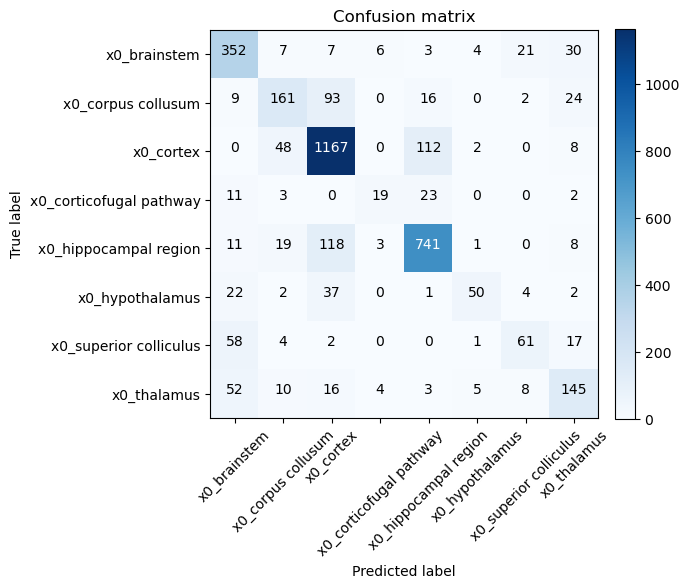

In [103]:
cf_matrix = confusion_matrix(y_valid,pred_label)
plot_confusion_matrix(cf_matrix, classes=enc.get_feature_names())
#plt.savefig('../figures/confuse_mtx_all3d.pdf')

In [104]:
import shap
explainer = shap.TreeExplainer(model)

In [105]:
SHAP_values = []
for i in tqdm(range(0,region_data.shape[0],10)):
    shap_values = explainer.shap_values(region_data[i:i+10,:])
    SHAP_values.append(shap_values)

100%|██████████████████████████████████████| 3535/3535 [00:22<00:00, 159.19it/s]


In [107]:
SHAP_values_all = []
for i in range(8):
    SHAP_values_all.append(np.concatenate([shap_list[i] for shap_list in SHAP_values]))

In [108]:
mean_shap = np.abs(np.stack(SHAP_values_all)).mean(1)
rank_shap = np.argsort(mean_shap.mean(0))
rank_entropy = np.argsort(model.feature_importances_)

In [52]:
np.stack([mean_shap,mean_shap],2).shape

(5, 1156, 2)

In [196]:
shap_umap_ = np.load('../processed_data/shap_umap_0.pkl.npy')

In [199]:
def IonImg_transform(data, spec_idx_transform, background):
    if background:
        ion_img_transform = np.zeros(spec_idx_transform.size)
    else:
        ion_img_transform = np.empty(spec_idx_transform.size)
        ion_img_transform[:] = np.nan
    img_shape = spec_idx_transform.shape
    spec_idx_transform_flatten = spec_idx_transform.flatten()
    ion_img_transform[spec_idx_transform_flatten!=0] = data[spec_idx_transform_flatten[spec_idx_transform_flatten!=0]-1]
    ion_img_transform = ion_img_transform.reshape(img_shape)
    
    return ion_img_transform
from scipy.io import loadmat
shap_umap_imgs = []
spec_idx_transformed = loadmat('../image_register/Matlab Registration/coronal_registration/spec_idx_imgs_transformed.mat')['spec_idx_imgs_transformed']
for i in range(3):
    img = IonImg_transform(shap_umap_[:,i],spec_idx_transformed[:,:,0], True).T
    img = (img-shap_umap_[:,i].min())/(shap_umap_[:,i].max()-shap_umap_[:,i].min())
    #img *= np.uint8(255/np.nanmax(img))
    shap_umap_imgs.append(img)
shap_umap_imgs = np.stack(shap_umap_imgs,2)


In [200]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

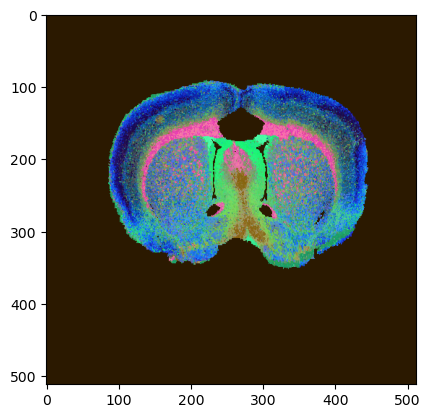

In [201]:
import matplotlib.pyplot as plt
plt.imshow(shap_umap_imgs)


In [173]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(model.feature_importances_),np.log10(mean_shap.mean(0)),c=np.log10(average_spec_region.mean(0)),
           cmap='inferno')

TypeError: 'NoneType' object is not iterable

<Figure size 500x500 with 0 Axes>

In [25]:
import numpy as np
mean_shap = np.load('../processed_data/mean_shap_slice_0.npy')
rank_shap = np.argsort(mean_shap.mean(0))

In [26]:
mean_shap_df = pd.DataFrame(mean_shap.T,columns=enc.categories_[0])

In [30]:
mean_shap_df

,basal forebrain,corpus collusum,cortex,septal region,striatum
0,0.005313,0.095954,0.000000,0.004512,0.000061
1,0.001535,0.000000,0.000000,0.000233,0.000000
2,0.003191,0.000000,0.002166,0.000000,0.000107
3,0.000332,0.000000,0.000000,0.000382,0.000055
4,0.004727,0.000920,0.002913,0.016736,0.000000
...,...,...,...,...,...
1151,0.002986,0.006675,0.019089,0.008746,0.007448
1152,0.000000,0.000000,0.006109,0.000000,0.001287
1153,0.000000,0.000175,0.006964,0.000228,0.005859
1154,0.000000,0.002091,0.000689,0.003619,0.001556


In [34]:
rank_shap[::-1][:20]

array([ 521,  704,  627, 1106,   74,  589, 1128,  249,  191,  176,  960,
        819,  591,  984,  736,  708, 1120,  890, 1041,  605])

NameError: name 'region_data_df' is not defined

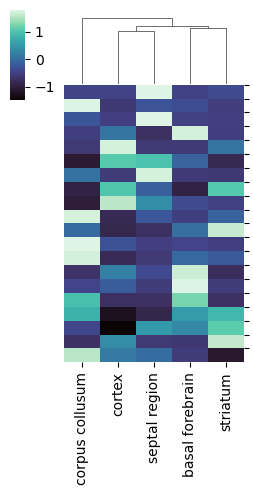

In [35]:
ax = sns.clustermap(mean_shap_df.iloc[rank_shap[::-1][:20]],row_cluster=False,cmap="mako",figsize=(3,5),z_score=0)
ax.ax_heatmap.axes.set_yticks(np.arange(0,20),rotation=90)
ax.ax_heatmap.axes.set_yticklabels(region_data_df.columns[rank_shap[::-1]][:20],rotation=0)
ax.ax_heatmap.axes.yaxis.tick_right()
ax.cax.set_visible(False)
#plt.savefig('../figures/meanshap_top20_slice_{}.pdf'.format(slice_no))

In [1]:
import seaborn as sns
iris = sns.load_dataset("iris")

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
annot_df_3d = pd.read_pickle('../processed_data/coronal3d_annot_lipidmaps.pkl')

In [30]:
annot_select = annot_df_3d[annot_df_3d['Input m/z'].isin(average_spec_region.columns[rank_entropy[::-1][:300]])]

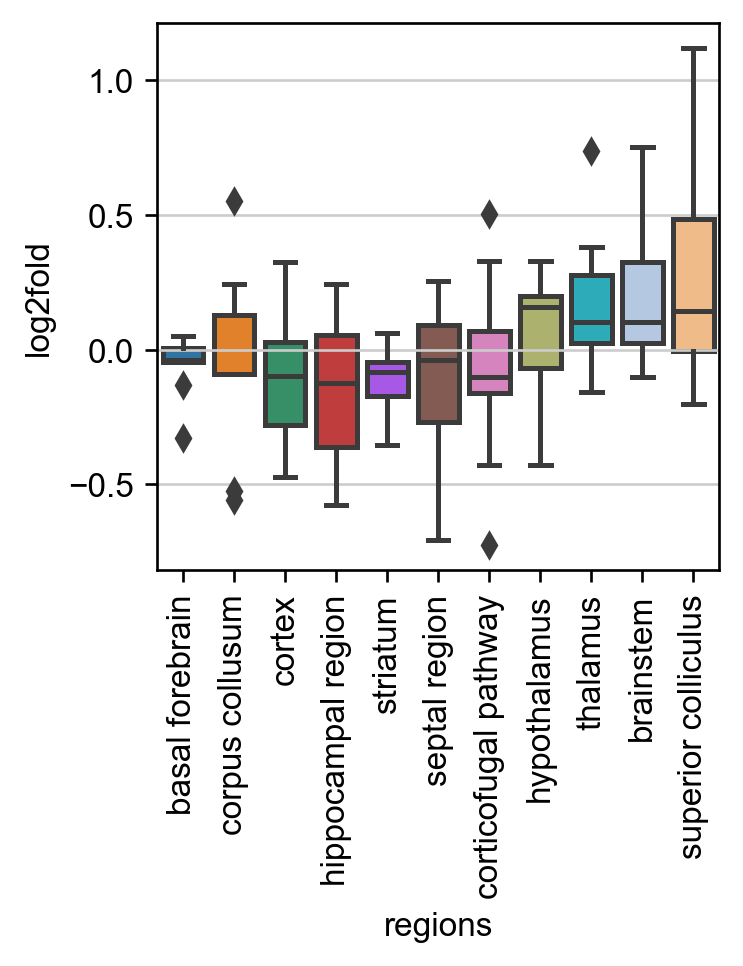

In [50]:
hexcer_feat = annot_select[(annot_select['Name'].str.contains('HexCer'))&(annot_select['Ion'].str.contains('H'))]['Input m/z']
hexcer_log2fold = []
hexcer_regions = []
regions = average_spec_region_metadata['regions']
for region in regions.unique():
    treated_data = average_spec_region[hexcer_feat].iloc[np.array(regions)==region].values
    nontreated_data = average_spec_region[hexcer_feat].iloc[np.array(regions)!=region].values
    treated_mean = treated_data.mean(0)
    nontreated_mean = nontreated_data.mean(0)
    log2fold = np.log2(treated_mean/nontreated_mean)
    hexcer_log2fold+=list(log2fold)
    hexcer_regions+=[region]*log2fold.shape[0]
    
sns.boxplot(data=pd.DataFrame({'log2fold':hexcer_log2fold,'regions':hexcer_regions}),x='regions',y='log2fold')
plt.xticks(rotation=90)
plt.savefig('../figures/hexcer_coronal3d.pdf')

In [6]:
# annot_select[(annot_select['Name'].str.contains('HexCer'))&(annot_select['Ion'].str.contains('H'))][:10]

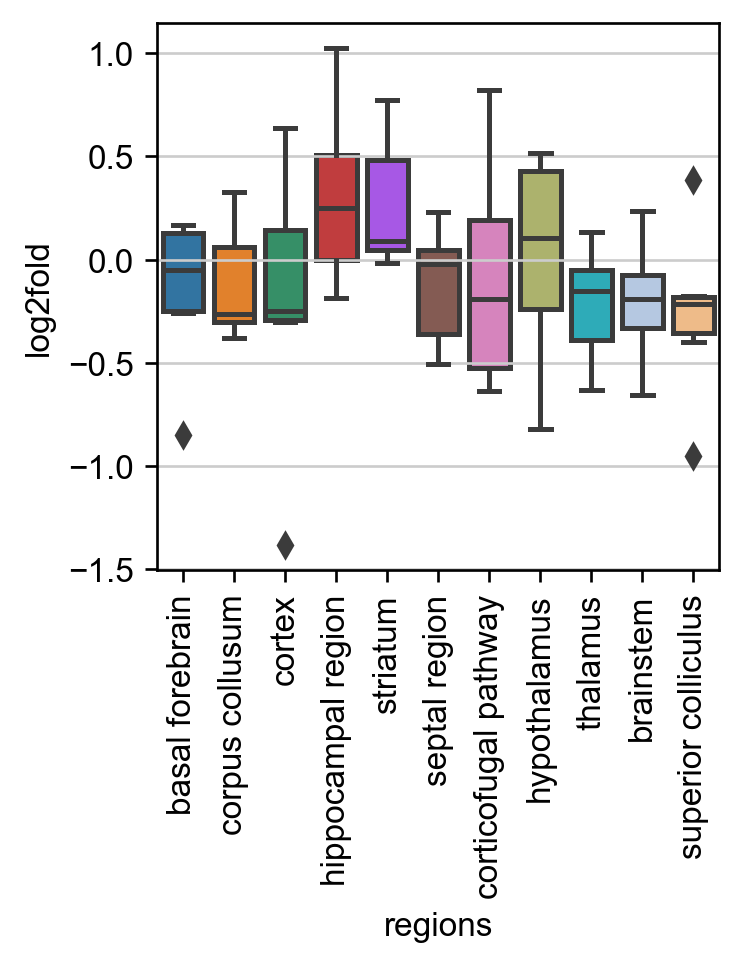

In [155]:
sm_feat = annot_select[(annot_select['Name'].str.contains('SM'))&(annot_select['Ion'].str.contains('K'))]['Input m/z']
sm_log2fold = []
sm_regions = []
regions = average_spec_region_metadata['regions']
for region in regions.unique():
    treated_data = average_spec_region[sm_feat].iloc[np.array(regions)==region].values
    nontreated_data = average_spec_region[sm_feat].iloc[np.array(regions)!=region].values
    treated_mean = treated_data.mean(0)
    nontreated_mean = nontreated_data.mean(0)
    log2fold = np.log2(treated_mean/nontreated_mean)
    sm_log2fold+=list(log2fold)
    sm_regions+=[region]*log2fold.shape[0]
    
sns.boxplot(data=pd.DataFrame({'log2fold':sm_log2fold,'regions':sm_regions}),x='regions',y='log2fold')
plt.xticks(rotation=90)
plt.savefig('../figures/sm_coronal3d.pdf')

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'basal forebrain'),
  Text(1, 0, 'corpus collusum'),
  Text(2, 0, 'cortex'),
  Text(3, 0, 'hippocampal region'),
  Text(4, 0, 'striatum'),
  Text(5, 0, 'septal region'),
  Text(6, 0, 'corticofugal pathway'),
  Text(7, 0, 'hypothalamus'),
  Text(8, 0, 'thalamus'),
  Text(9, 0, 'brainstem'),
  Text(10, 0, 'superior colliculus')])

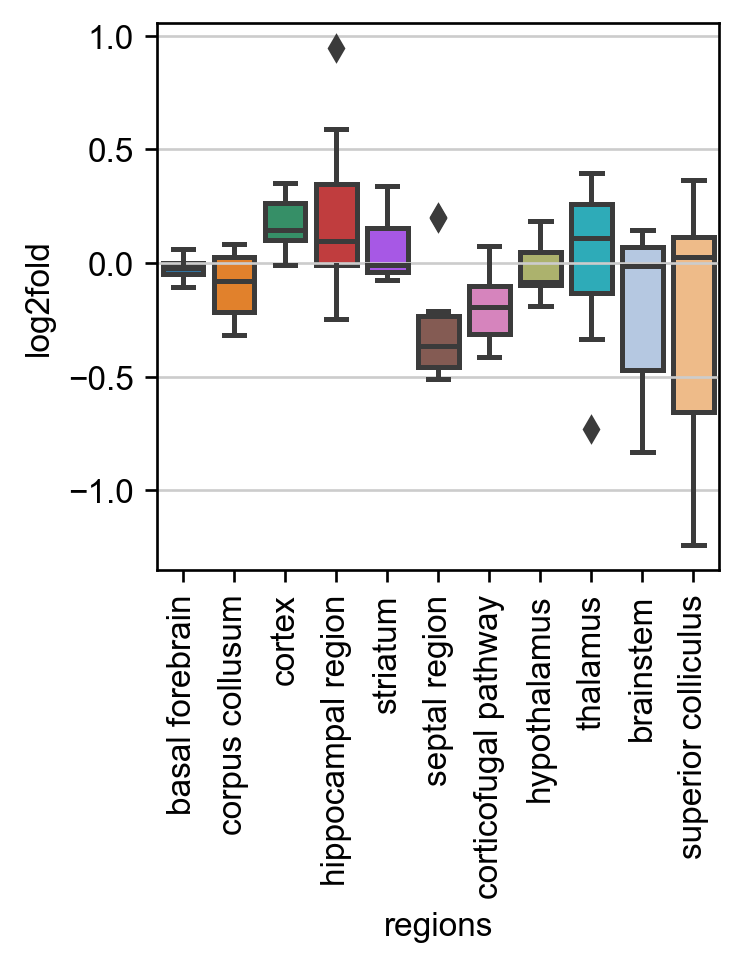

In [157]:
hexcer_feat = annot_select[(annot_select['Name'].str.contains('CerP'))&(annot_select['Ion'].str.contains('K'))]['Input m/z'][:10]
hexcer_log2fold = []
hexcer_regions = []
regions = average_spec_region_metadata['regions']
for region in regions.unique():
    treated_data = average_spec_region[hexcer_feat].iloc[np.array(regions)==region].values
    nontreated_data = average_spec_region[hexcer_feat].iloc[np.array(regions)!=region].values
    treated_mean = treated_data.mean(0)
    nontreated_mean = nontreated_data.mean(0)
    log2fold = np.log2(treated_mean/nontreated_mean)
    hexcer_log2fold+=list(log2fold)
    hexcer_regions+=[region]*log2fold.shape[0]
    
sns.boxplot(data=pd.DataFrame({'log2fold':hexcer_log2fold,'regions':hexcer_regions}),x='regions',y='log2fold')
plt.xticks(rotation=90)
#plt.savefig('../figures/cer_coronal3d.pdf')


In [167]:
hexcer_images_set = [reg.get_3DImages_transform(511,True),reg.get_3DImages_transform(605,True),reg.get_3DImages_transform(770,True),
             reg.get_3DImages_transform(922,True),reg.get_3DImages_transform(930,True),reg.get_3DImages_transform(964,True),
             reg.get_3DImages_transform(997,True),reg.get_3DImages_transform(1087,True),reg.get_3DImages_transform(441,True)
                    ,reg.get_3DImages_transform(270,True),reg.get_3DImages_transform(818,True)]


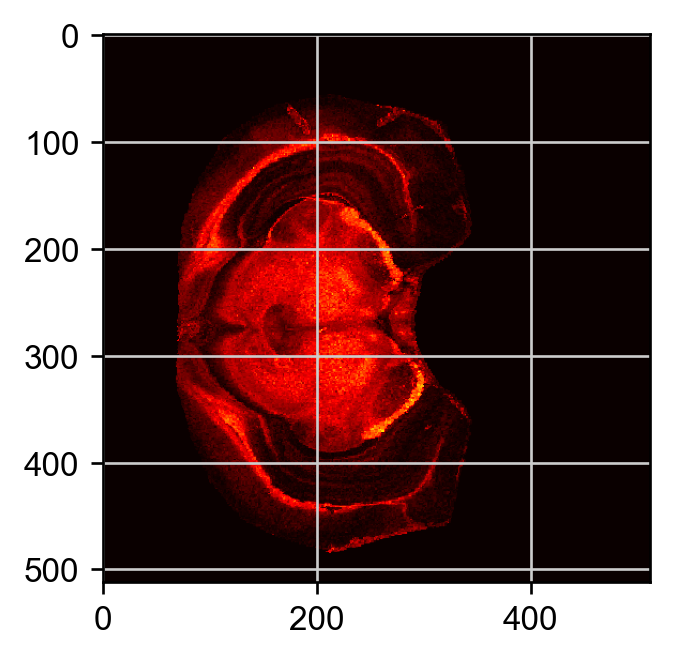

In [168]:
plt.imshow(hexcer_images_set[-1][12],'hot')
#plt.savefig('../figures/cer_1.pdf',dpi=300)
plt.imshow(hexcer_images_set[-1][21],'hot')
#plt.savefig('../figures/cer_2.pdf',dpi=300)

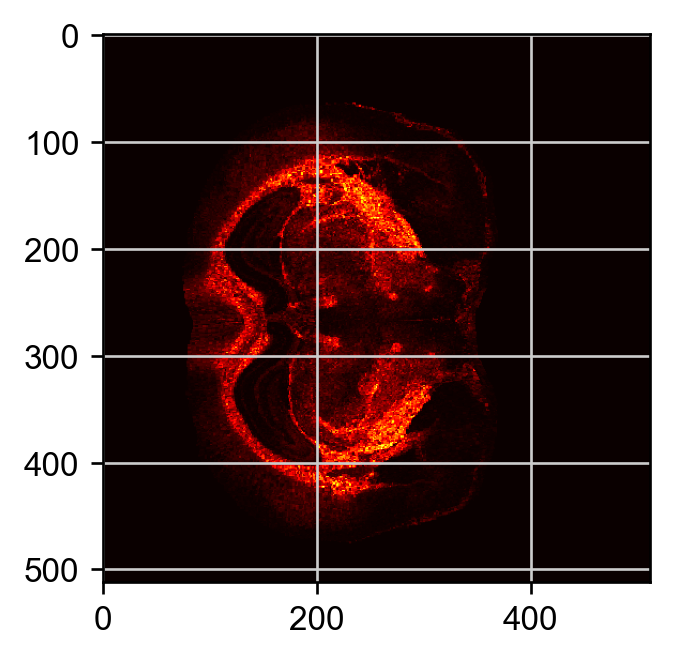

In [129]:
plt.imshow(hexcer_images_set[-1][12],'hot')


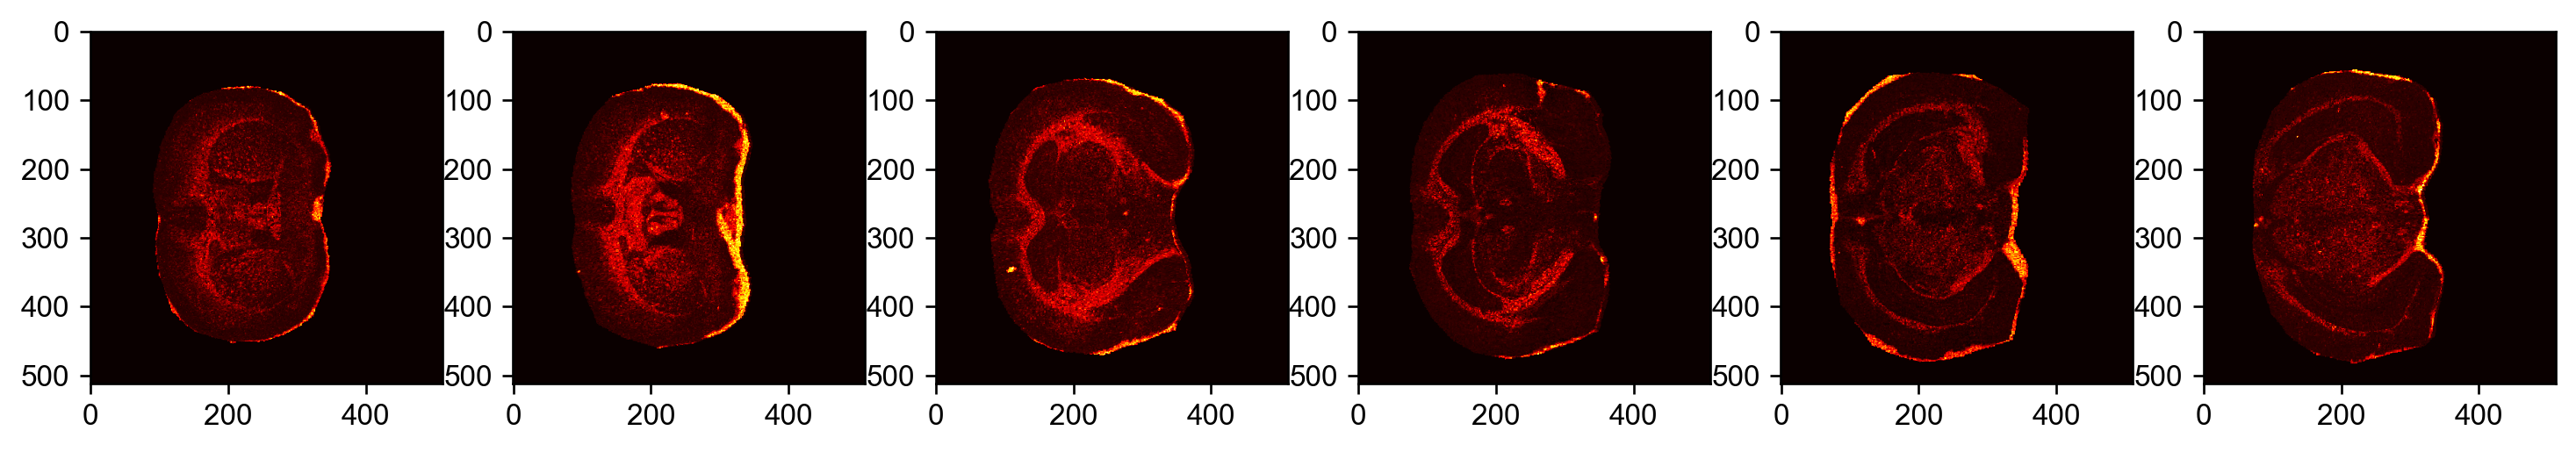

In [173]:
idx = 341
plt.rcParams["axes.grid"] = False
fig,axes=plt.subplots(1,6,figsize=(15,3))
ax = axes.ravel()
ax[0].imshow(reg.get_3DImages_transform(idx,True)[3],'hot')
ax[1].imshow(reg.get_3DImages_transform(idx,True)[5],'hot')
ax[2].imshow(reg.get_3DImages_transform(idx,True)[8],'hot')
ax[3].imshow(reg.get_3DImages_transform(idx,True)[13],'hot')
ax[4].imshow(reg.get_3DImages_transform(idx,True)[16],'hot')
ax[5].imshow(reg.get_3DImages_transform(idx,True)[20],'hot')
fig.savefig('../figures/coronal_cortex_341mz.pdf',dpi=300)